In [4]:
import seaborn as sns
import pandas as pd
import datetime as dt


In [5]:
df = pd.read_parquet('dozzle.parquet')
df['UserID'] = pd.util.hash_array(df['RemoteIP'].to_numpy())
df.drop(['RemoteIP', 'HasHostname', 'FilterLength', 'HasDocumentation', 'Clients', 'HasActions', 'Browser', 'HasCustomBase', 'HasCustomAddress'], axis=1, inplace=True)

In [6]:
df['activated'] = df.groupby('UserID')["CreatedAt"].transform('min')
df['activated_week'] = df['activated'].dt.isocalendar().year * 52 + df['activated'].dt.isocalendar().week
df['current_week'] = df['CreatedAt'].dt.isocalendar().year * 52 + df['CreatedAt'].dt.isocalendar().week
df['cohort_index'] = (df['current_week'] - df['activated_week'])

<Axes: xlabel='cohort_index'>

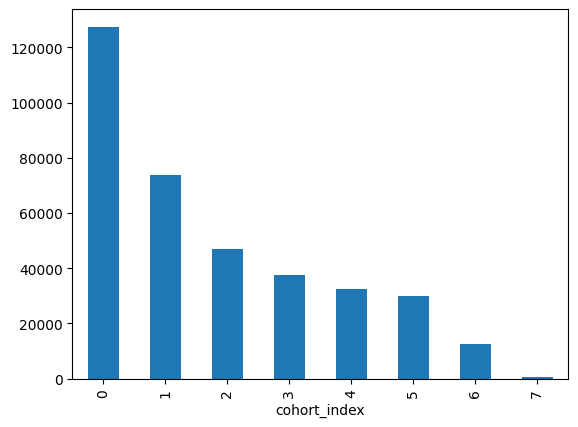

In [7]:
df['cohort_index'].value_counts().sort_index().plot(kind='bar')


In [8]:
cohort_counts = df.groupby(['activated_week', 'cohort_index'])['UserID'].nunique()
cohort_counts_df = cohort_counts.to_frame().rename(columns={'UserID':'users'}).sort_values(by=['activated_week'])
cohort_counts_df['retention_rate'] = cohort_counts_df['users'] / cohort_counts_df.groupby(["activated_week"])["users"].transform("max")
cohort_counts_df['activated_date'] = cohort_counts_df.index.get_level_values(0).map(lambda x: dt.datetime.strptime(f'{int(x/52)}-{x % 52}-1', "%Y-%W-%w").strftime("%Y-%m-%d"))
cohort_counts_df = cohort_counts_df.reset_index().set_index(['activated_date', 'cohort_index']).drop(['activated_week'], axis=1)
cohorts_pivot = cohort_counts_df.pivot_table(index='activated_date', columns='cohort_index', values='retention_rate')


<Axes: xlabel='cohort_index', ylabel='activated_date'>

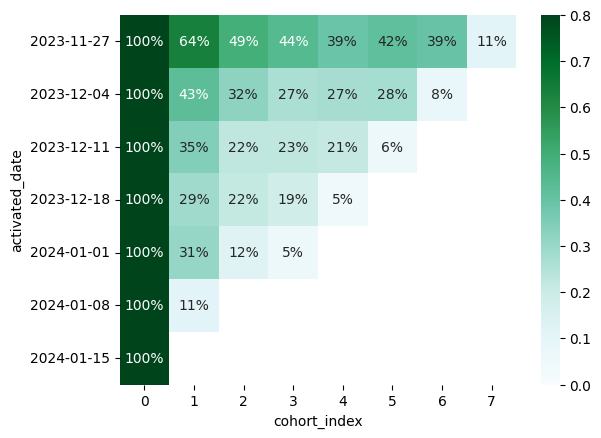

In [10]:
sns.heatmap(data = cohorts_pivot,
            annot = True,
            fmt = '.0%',
            vmin = 0.0,
            vmax = 0.8,
            cmap = 'BuGn')